In [19]:
using Plots
using FastGaussQuadrature
using LaTeXStrings
using LinearAlgebra

In [20]:
#ガウスルジャンドルの積分区間変更

function transform(deg::Int64, a::Float64, b::Float64)
    @assert a < b
    x, α = gausslegendre(deg)
    dx = b-a

    new_x = 0.5 .* dx .* x .+ (0.5*(a+b))
    new_α = 0.5 .* dx .* α
    
    return new_x, new_α
end

transform (generic function with 1 method)

超伝導のペアポテンシャル$\Delta$に対する次の方程式(ギャップ方程式)
$$
\Delta = VN_0\int_{0}^{\hbar\omega_D}d\varepsilon \dfrac{\Delta}{\sqrt{\varepsilon^2 + \Delta^2}}\tanh\left(\dfrac{\sqrt{\varepsilon^2 + \Delta^2}}{2k_{\mathrm{B}}T}\right)
$$
を解くぜ！！

In [21]:
#被積分関数
f(ε, Δ, VN0, hw, kT) = (VN0 * Δ * tanh( sqrt(ε^2 + Δ^2)/(2*kT) )) / sqrt(ε^2 + Δ^2) 

#T=0のギャップ
ΔT0(hw, VN0) = 2 * hw * exp(-1/VN0)

#右辺を計算する関数
function Gapright(f, Δ, VN0, hw, kT, deg::Int64)
    ε, a = transform(deg, 0.0, hw)
    int = dot(a, f.(ε, Δ, VN0, hw, kT))
    return int
end

Gapright (generic function with 1 method)

In [22]:
#とりあえずの設定(後で規格化するからなんでもよい？)
VN0 = 0.1
hw = 0.1
deg = 1000
N = 100

#転移温度理論値
kTc_analysis = 1.13 * hw * exp(-1/VN0)

#温度プロット範囲
kTs = range(1e-20, 1.2 * kTc_analysis, N)

#T=0のでペアポテンシャル
Δ0 = 2*hw*exp(-1/VN0)

ans = []
;

In [23]:
#被積分関数のプロット

εs = range(0.0, 1000, length = N)

plot(εs, f.(εs, 1.0, VN0, hw, kTs[90]))
;

In [24]:
#各温度で自己無撞着計算

for kT in kTs
    Δ0 = 1.0
    for i in 1:10000
        Δ1 = Gapright(f, Δ0, VN0, hw, kT, deg)
        if abs(Δ1-Δ0) < 1e-20
            break
        end
        Δ0 = Δ1
    end
    ans = push!(ans, Δ0)
end

In [25]:
#T=0とT=Tc付近での振る舞い(理論)
Δ0 = ΔT0(hw, VN0)

ΔTcs = []
for i in 1:N
    if kTc_analysis - kTs[i] > 0
        push!(ΔTcs, Δ0*tanh(1.74*sqrt((kTc_analysis-kTs[i])/(kTs[i]))))
    else 
        push!(ΔTcs, 0.0)
    end
end


#近似したTcで近似したもの(理論)
f(T) = Δ0 * 1.74 * sqrt((kTc_analysis - T)/(T))
ΔTcs_app = []
for j in 1:N
    if kTc_analysis - kTs[j] > 0
        push!(ΔTcs_app, f(kTs[j]))
    else
        push!(ΔTcs_app, 0.0)
    end
end

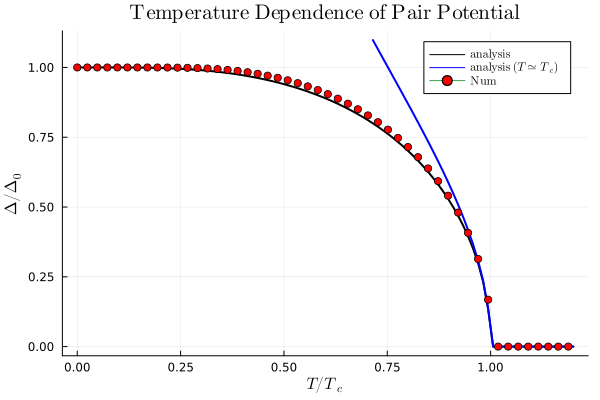

In [26]:
#グラフの作成
p = plot()

#全区間近似式
plot!(p, kTs/kTc_analysis, ΔTcs/Δ0,
        label = L"\mathrm{analysis}",
        linecolor = :black,
        linewidth = 2,)

#Tc付近の近侍式
plot!(p, kTs[Int64(0.6*N):N]/kTc_analysis, ΔTcs_app[Int64(0.6*N):N]/Δ0,
        label = L"\mathrm{analysis}~(T \simeq T_c)",
        linewidth = 2,
        linecolor = :blue)

#数値解析結果
plot!(p, kTs[1:2:end]/kTc_analysis, ans[1:2:end]/Δ0,
        title = L"\mathrm{Temperature~Dependence~of~Pair~Potential}",
        label = L"\mathrm{Num}",
        xlabel = L"T/T_c",
        ylabel = L"\Delta/\Delta_0",
        markershape = :circle,
        linewidth = 0,
        background_color_legend	 = :white,
        markercolor = :red)

savefig("Gap_plot.pdf")

p